In [1]:
import os 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import h5py
import numpy as np 


from scipy.integrate import simps
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline
from PIL import Image

sns.set_context("talk")

%matplotlib inline

In [2]:


# Fit the resolution data to a polynomial for extrapolation
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Create a function to get resolution for any energy
def get_resolution(e,popt):
    return np.maximum(poly_func(e, *popt), 1e-10)  # Ensure non-zero resolution


# Perform Gaussian broadening using convolution with energy-dependent widths
def gaussian_broadening(dos, energy, sigmas):
    broadened_dos = np.zeros_like(dos)
    for i in range(len(energy)):
        # Create a Gaussian kernel centered at each energy point with width sigmas[i]
        kernel = np.exp(-0.5 * ((energy - energy[i]) / sigmas[i])**2)
        kernel /= simps(kernel, energy)  # Normalize the kernel to preserve area
        broadened_dos += dos[i] * kernel  # Convolve DOS with Gaussian kernel
    return broadened_dos

def apply_gaussian_broadening(dos_data,metric='dos total (nm2/ps)',unit_cell_atoms=1):
    energy = dos_data['Energy Transfer (meV)'].values
    dos = dos_data[metric].values

    resolution_data = pd.read_csv('../data/experiment/resolution.csv')
    res_energy = resolution_data['Energy (meV)'].values
    resolution = resolution_data['Resolution'].values
    popt, _ = curve_fit(poly_func, res_energy, resolution)
    
    # Create an array of sigmas for Gaussian broadening based on the resolution function
    sigmas = get_resolution(energy,popt) / np.sqrt(8 * np.log(2))  # Convert FWHM to sigma


    broadened_dos = gaussian_broadening(dos, energy, sigmas)

    # Area normalize both original and broadened DOS
    original_area = simps(dos, energy)
    broadened_area = simps(broadened_dos, energy)

    dos_normalized = dos / original_area
    broadened_dos_normalized = broadened_dos / broadened_area
    return 3*unit_cell_atoms*broadened_dos_normalized

In [4]:
results_directory={}
for temperature in np.arange(100,450,50):
    results_directory["../results/gromacs/nanoparticle/H2O/2nm/temperature/results/md_phonon_%d/"%temperature]=temperature
df_list=list()

min_energy=0.25
max_energy=500

for data_directory,temperature in results_directory.items():
    for filename in os.listdir(data_directory):
        if not "dos.h5" in filename:
            continue
        print(os.path.join(data_directory,filename))
        h5file=h5py.File(os.path.join(data_directory,filename))
        data_dict=dict()
        omega_shape=h5file["omega"][:].shape
        for k in h5file.keys():
            data_array=h5file[k][:]
            if data_array.shape != omega_shape or "_0" in k:
                continue
            units=h5file[k].attrs['units']
            data_dict["%s (%s)"%(k.replace("_"," "),units)]=data_array
        df_tmp=pd.DataFrame(data_dict).query("%f < `omega (rad/ps)` and `omega (rad/ps)` < %f"%(min_energy/0.6582,max_energy/0.6582))
        directory_split=data_directory.split("/")
        system=directory_split[3]
        df_tmp["Temperature (K)"]=temperature
        df_tmp["Weight"]=" ".join(filename.split("_")[:-1]).replace('b ','').capitalize()
        df_tmp["Method"]="GROMACS"
        df_tmp["Force Field"]="LJ"
        df_tmp["Energy Transfer (meV)"]=df_tmp["omega (rad/ps)"]*0.6582
        df_tmp["Normalized Count"]=apply_gaussian_broadening(df_tmp,unit_cell_atoms=137)
        for species,unit_cell_atoms in {"Fe":105-32,"O":32,"H":1}.items():
            df_tmp[species]=apply_gaussian_broadening(df_tmp,"dos %s (nm2/ps)"%species,unit_cell_atoms)
            df_tmp["Max Normalized %s"%species]=df_tmp[species]/df_tmp[species].max()
        df_tmp["Max Normalized Count"]=df_tmp["Normalized Count"]/df_tmp["Normalized Count"].max()
        df_tmp["Radius (nm)"]=int(directory_split[5].replace("nm",""))
        df_tmp["Software"]=directory_split[2]
        df_tmp["System"]=system #.split("_")[0].replace("nanoparticle", "np")
        
        df_list.append(df_tmp)
        
df_dos_gromacs=pd.concat(df_list,ignore_index=True)


../results/gromacs/nanoparticle/H2O/2nm/temperature/results/md_phonon_100/b_coherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/temperature/results/md_phonon_100/b_incoherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/temperature/results/md_phonon_150/b_coherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/temperature/results/md_phonon_150/b_incoherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/temperature/results/md_phonon_200/b_coherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/temperature/results/md_phonon_200/b_incoherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/temperature/results/md_phonon_250/b_coherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/temperature/results/md_phonon_250/b_incoherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/temperature/results/md_phonon_300/b_coherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/temperature/results/md_phonon_300/b_incoherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/temperature/results/md_phonon_

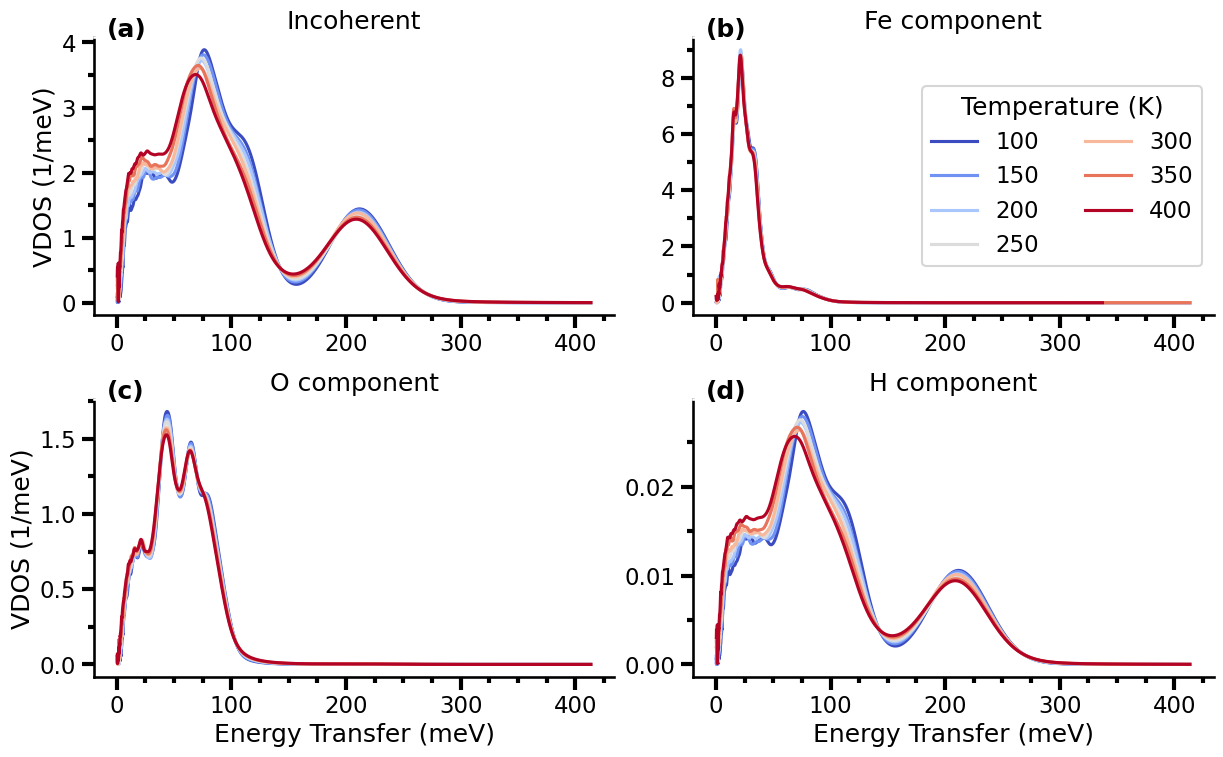

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/home/galavizp/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3908, in atexit_operations
    self.history_manager.end_session()
  File "/home/galavizp/.local/lib/python3.8/site-packages/IPython/core/history.py", line 576, in end_session
    self.db.execute("""UPDATE sessions SET end=?, num_cmds=? WHERE
sqlite3.OperationalError: disk I/O error


In [5]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(7*2,4*2)
                       # ,height_ratios =(3,2)
                       )
sns.set_context("talk")


emin,emax=0.,510
weight="Incoherent"

labx=0.025
laby=1

labels=list("abcd")
for i, yval in enumerate(["Normalized Count","Fe","O","H"]):

    ax=axs[i//2,i%2]
    ax.text(labx, laby, '(%s)'%labels[i],weight='bold' ,transform=ax.transAxes)

    sns.lineplot(data=df_dos_gromacs.query(" %f < `Energy Transfer (meV)` and `Energy Transfer (meV)` < %f and Weight== '%s' and `%s` > 0"%(emin,emax,weight,yval))
                        ,y=yval
                        ,x='Energy Transfer (meV)'
                        ,hue="Temperature (K)"
                         ,ax=ax
                 ,palette="coolwarm"
                 ,hue_order=np.arange(100,450,50)
                 ,legend=i==1
                   )

    ax.spines['bottom'].set_color('0')
    ax.spines['top'].set_color('1')
    ax.spines['right'].set_color('1')
    ax.spines['left'].set_color('0')
    ax.tick_params(direction='out', width=3, bottom=True, left=True)
    ax.grid(False)
    if i < 2 :
        ax.set_xlabel("")
    if i==1:
        sns.move_legend(ax,'center right',bbox_to_anchor=(1,0.5),ncol=2
                   # ,bbox_transform=fig.transFigure
                   )
    if i%2==1:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("VDOS (1/meV)")

        
    ax.xaxis.set_minor_locator(MultipleLocator(100/4))
    ax.yaxis.set_minor_locator(MultipleLocator([1/2,1,0.25,0.005][i]))
    ax.tick_params(which='minor', length=4,width=3)
    ax.set_title("%s component"%yval if yval != "Normalized Count" else weight)
    

    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=0.3)
plt.savefig("../figures/fig12.pdf", pad_inches=0.2,bbox_inches="tight")